<a href="https://colab.research.google.com/github/ameranismail/DLproject-/blob/main/DLproject_CancerCerbral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Une tumeur cérébrale survient lorsque des cellules anormales se forment dans le cerveau. Il existe deux principaux types de tumeurs: les tumeurs cancéreuses (malignes) et les tumeurs bénignes. Les tumeurs cancéreuses peuvent être divisées en tumeurs primaires, qui commencent dans le cerveau, et en tumeurs secondaires, qui se sont propagées ailleurs, appelées tumeurs de métastases cérébrales. Tous les types de tumeurs cérébrales peuvent produire des symptômes qui varient selon la partie du cerveau impliquée. Ces symptômes peuvent inclure des maux de tête, des convulsions, des problèmes de vision, des vomissements et des changements mentaux. Le mal de tête est classiquement pire le matin et disparaît avec des vomissements. D'autres symptômes peuvent inclure des difficultés à marcher, à parler ou à ressentir. À mesure que la maladie progresse, une perte de conscience peut survenir.

#Téléchargement et Processing de Data 

### Se connecter à Kaggle pour telecharger la Data

In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ismailameran","key":"d0641095f1639ce97a401324cebac299"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 60% 9.00M/15.1M [00:01<00:00, 7.79MB/s]
100% 15.1M/15.1M [00:01<00:00, 14.9MB/s]


In [4]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

#Importer Libraries 

In [5]:
from builtins import range, input

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob
import imutils
import matplotlib.pyplot as plt
from os import listdir
from PIL import Image
import time    

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

#Augmenter Data

In [6]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '//' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [7]:


augmented_data_path = '/content/augmented_data'

# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir='/content/yes/', n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir='/content/no/', n_generated_samples=9, save_to_dir=augmented_data_path+'no')


In [30]:
# number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
m_pos = len(listdir('/content/augmented_datayes'))
# number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
m_neg = len(listdir('/content/augmented_datano'))
# number of all examples
m = (m_pos+m_neg)
   
pos_prec = (m_pos* 100.0)/ m
neg_prec = (m_neg* 100.0)/ m
    
print(f"Number of examples: {m}")
print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

Number of examples: 2064
Percentage of positive examples: 52.51937984496124%, number of pos examples: 1084
Percentage of negative examples: 47.48062015503876%, number of neg examples: 980


### Define Few Parameters

In [8]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]


#define paths
tumor_path = '/content/augmented_datayes'
notumor_path = '/content/augmented_datano'

# Use glob to grab images from path .jpg or jpeg
tumor_files = glob(tumor_path + '/*')
notumor_files = glob(notumor_path + '/*')

In [9]:
# Visualize file variable contents
print("First 5 tumor Files: ",tumor_files[0:5])
print("Total Count: ",len(tumor_files))
print("First 5 Notumor Files: ",notumor_files[0:5])
print("Total Count: ",len(notumor_files))

First 5 tumor Files:  ['/content/augmented_datayes/aug_Y259_0_1130.jpg', '/content/augmented_datayes/aug_Y98_0_9155.jpg', '/content/augmented_datayes/aug_Y120_0_7890.jpg', '/content/augmented_datayes/aug_Y104_0_7588.jpg', '/content/augmented_datayes/aug_Y184_0_3680.jpg']
Total Count:  1085
First 5 Notumor Files:  ['/content/augmented_datano/aug_No18_0_96.jpg', '/content/augmented_datano/aug_14 no_0_7848.jpg', '/content/augmented_datano/aug_no 5._0_2119.jpg', '/content/augmented_datano/aug_No16_0_2267.jpg', '/content/augmented_datano/aug_N11_0_8926.jpg']
Total Count:  980


### Fetch Images and Class Labels from Files (This might take a while)

In [10]:
# Fetch Images and Class Labels from Files
tumor_labels = []
notumor_labels = []

tumor_images=[]
notumor_images=[]

for i in range(len(tumor_files)):
  image = cv2.imread(tumor_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  tumor_images.append(image) # append image
  tumor_labels.append('MRI_TUMOR') #append class label
for i in range(len(notumor_files)):
  image = cv2.imread(notumor_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  notumor_images.append(image)
  notumor_labels.append('MRI_NoTUMOR')

### Visualize First 10 Images from Data set

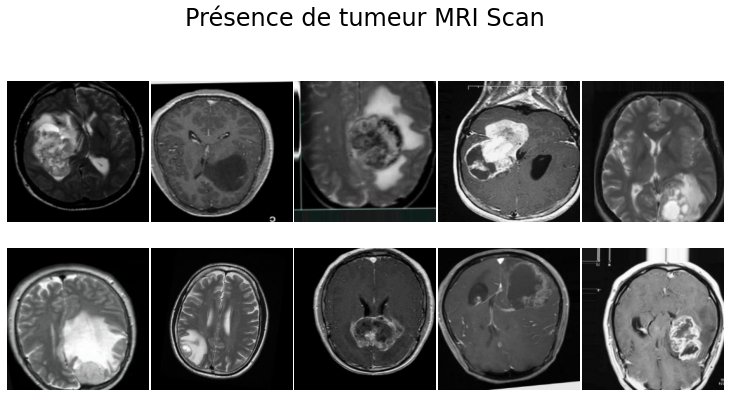

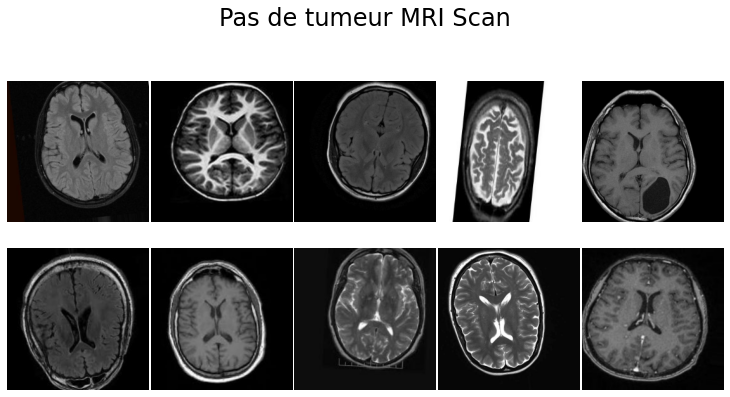

In [11]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 2, 5
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(tumor_images, 'Présence de tumeur MRI Scan')
plot_images(notumor_images, 'Pas de tumeur MRI Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [12]:
# Convert to array and Normalize to interval of [0,1]
tumor_images = np.array(tumor_images) / 255
notumor_images = np.array(notumor_images) / 255

### **Train Test valid Split**

In [13]:
# Split into training and testing sets for both types of images
tumor_x_train, tumor_x_test, tumor_y_train, tumor_y_test = train_test_split(
    tumor_images, tumor_labels, test_size=0.2)

tumor_x_test, tumor_x_valid, tumor_y_test, tumor_y_valid = train_test_split(
    tumor_x_test, tumor_y_test, test_size=0.5)

notumor_x_train, notumor_x_test, notumor_y_train, notumor_y_test = train_test_split(
    notumor_images, notumor_labels, test_size=0.2)

notumor_x_test, notumor_x_valid, notumor_y_test, notumor_y_valid = train_test_split(
    notumor_x_test, notumor_y_test, test_size=0.5)

# Merge sets for both types of images
X_train = np.concatenate((notumor_x_train, tumor_x_train), axis=0)
X_valid = np.concatenate((notumor_x_valid, tumor_x_valid), axis=0)
X_test = np.concatenate((notumor_x_test, tumor_x_test), axis=0)
y_train = np.concatenate((notumor_y_train, tumor_y_train), axis=0)
y_valid = np.concatenate((notumor_y_valid, tumor_y_valid), axis=0)
y_test = np.concatenate((notumor_y_test, tumor_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_valid = LabelBinarizer().fit_transform(y_valid)
y_valid = to_categorical(y_valid)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))
print ("X_valid shape: " + str(X_valid.shape))
print ("Y_valid shape: " + str(y_valid.shape))

number of training examples = 1652
number of test examples = 206
X_train shape: (1652, 224, 224, 3)
Y_train shape: (1652, 2)
X_test shape: (206, 224, 224, 3)
Y_test shape: (206, 2)
X_valid shape: (207, 224, 224, 3)
Y_valid shape: (207, 2)


### Visualize a few images from Training and Test sets

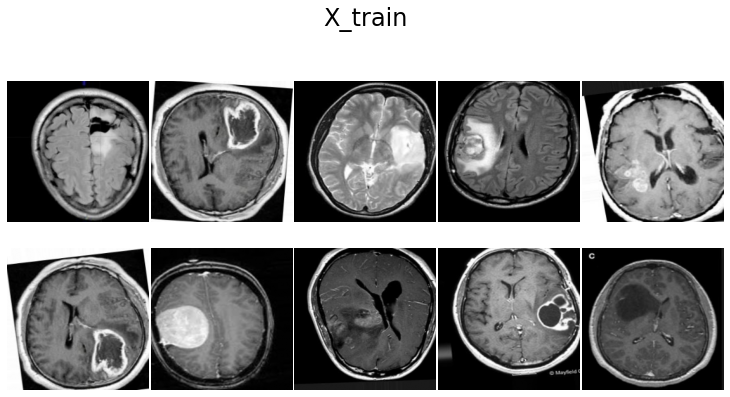

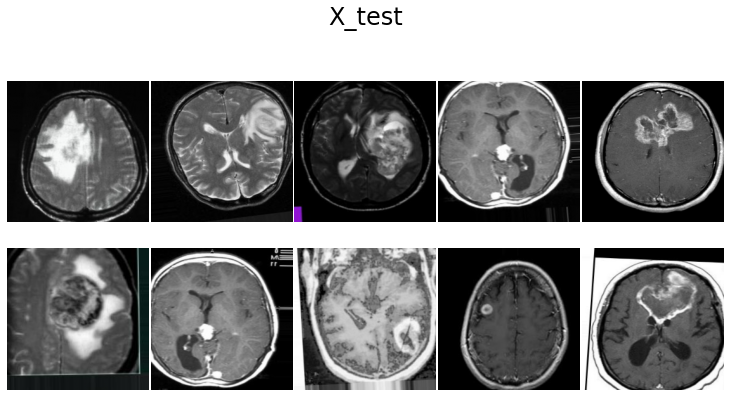

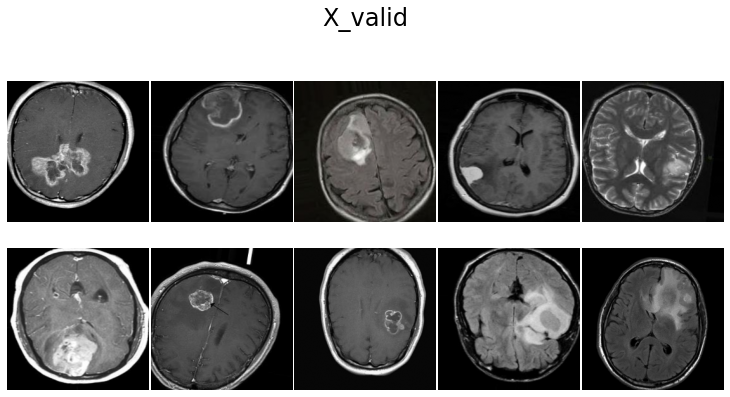

In [64]:
plot_images(tumor_x_train, 'X_train')
plot_images(tumor_x_test, 'X_test')
plot_images(tumor_x_valid, 'X_valid')

# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

#Pré-Trained Modele : Xception 

In [65]:
from tensorflow.keras.applications import Xception

### **Building and Visualizing model**

In [116]:
# Building Model
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_xception = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model_xception.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [117]:
# Visualize Model
model_xception.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

### **Training the model**

In [18]:
batch_size = 32
epochs = 10

In [118]:

history1 = model_xception.fit(X_train, y_train, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    epochs=epochs)

Epoch 1/10
52/52 [==============================] - 7s 101ms/step - loss: 1.6202 - accuracy: 0.7410 - val_loss: 0.2067 - val_accuracy: 0.9227
Epoch 2/10
52/52 [==============================] - 5s 88ms/step - loss: 0.2818 - accuracy: 0.9290 - val_loss: 0.2164 - val_accuracy: 0.9179
Epoch 3/10
52/52 [==============================] - 5s 88ms/step - loss: 0.2159 - accuracy: 0.9400 - val_loss: 0.0855 - val_accuracy: 0.9758
Epoch 4/10
52/52 [==============================] - 5s 88ms/step - loss: 0.1210 - accuracy: 0.9676 - val_loss: 0.1194 - val_accuracy: 0.9710
Epoch 5/10
52/52 [==============================] - 5s 88ms/step - loss: 0.0502 - accuracy: 0.9822 - val_loss: 0.0649 - val_accuracy: 0.9807
Epoch 6/10
52/52 [==============================] - 5s 88ms/step - loss: 0.0272 - accuracy: 0.9904 - val_loss: 0.0375 - val_accuracy: 0.9903
Epoch 7/10
52/52 [==============================] - 5s 88ms/step - loss: 0.0063 - accuracy: 0.9961 - val_loss: 0.0496 - val_accuracy: 0.9807
Epoch 8/10
5

In [119]:
xception_loss, xception_accuracy = model_xception.evaluate(X_test, y_test)

7/7 [==============================] - 1s 72ms/step - loss: 0.0792 - accuracy: 0.9854


In [120]:
# Save Model and Weights
model_xception.save('xception_rmi.h5')
model_xception.save_weights('xception_weights_rmi.hdf5')

In [121]:
# Load saved model
model_xception = load_model('xception_rmi.h5')

### **Predictions**

In [122]:
y_pred = model_xception.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

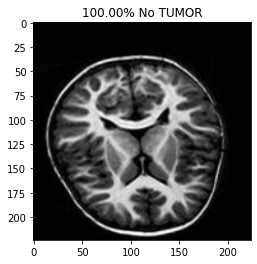

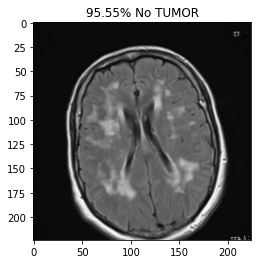

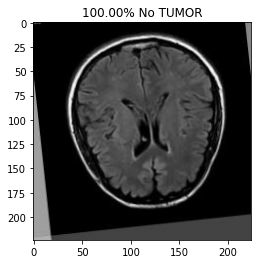

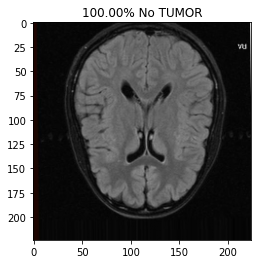

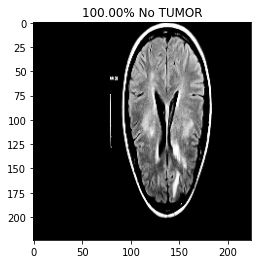

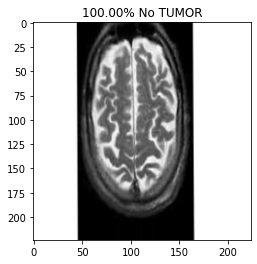

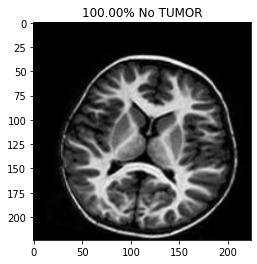

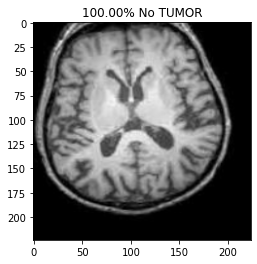

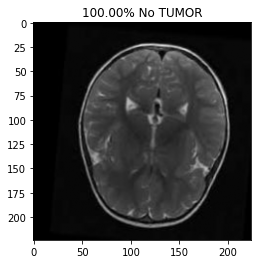

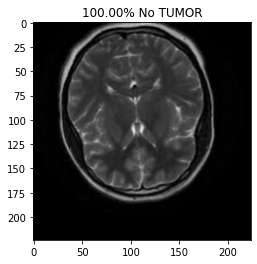

In [76]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.imshow(X_test[index])
  plt.show()

In [77]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot Confusion Matrix

Confusion Matrix without Normalization


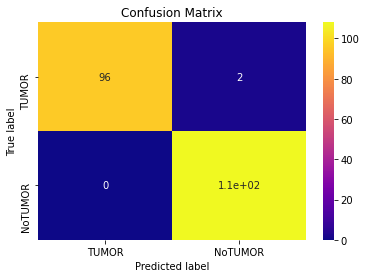

Confusion Matrix with Normalized Values


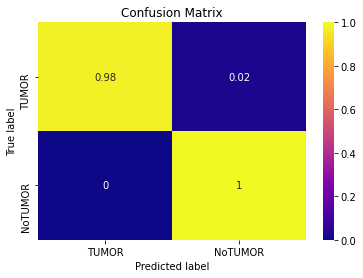

In [78]:
def plot_confusion_matrix(normalize):
  classes = ['TUMOR','NoTUMOR']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        98
           1       0.98      1.00      0.99       108

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



### **Accuracy and Loss Plots**

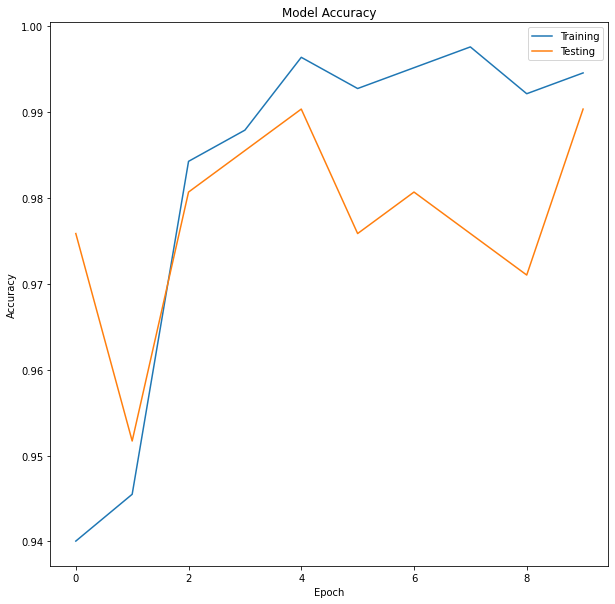

In [80]:
plt.figure(figsize=(5,5))

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_ct_accuracy.png')
plt.show()


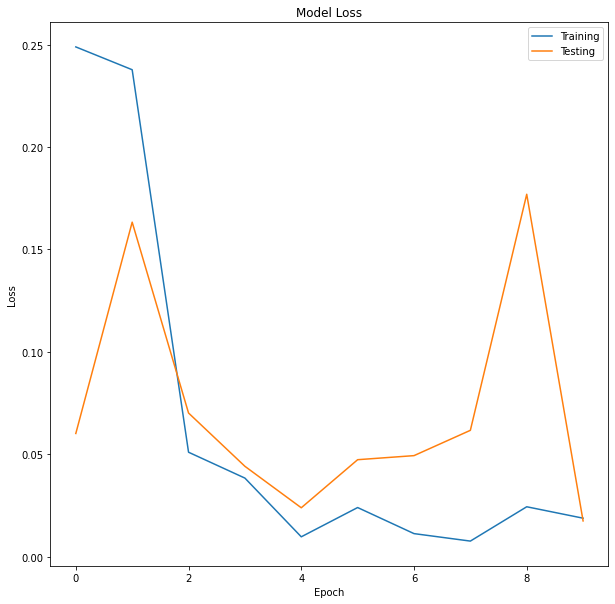

In [81]:
plt.figure(figsize=(10,10))

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_ct_loss.png')
plt.show()

#Pré-Trained Modele : InceptionV3

In [82]:
from tensorflow.keras.applications import InceptionV3

In [125]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_inceptionv3 = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model_inceptionv3.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
#visualize the model
model_inceptionv3.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 111, 111, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 111, 111, 32) 96          conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_106[0][0]    
____________________________________________________________________________________________

In [126]:
history2 = model_inceptionv3.fit(X_train, y_train, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    epochs=epochs)

Epoch 1/10
52/52 [==============================] - 7s 77ms/step - loss: 1.8360 - accuracy: 0.7390 - val_loss: 1.1127 - val_accuracy: 0.8019
Epoch 2/10
52/52 [==============================] - 3s 55ms/step - loss: 0.5520 - accuracy: 0.9021 - val_loss: 0.1762 - val_accuracy: 0.9662
Epoch 3/10
52/52 [==============================] - 3s 56ms/step - loss: 0.0646 - accuracy: 0.9806 - val_loss: 0.1795 - val_accuracy: 0.9469
Epoch 4/10
52/52 [==============================] - 3s 55ms/step - loss: 0.0573 - accuracy: 0.9817 - val_loss: 0.1066 - val_accuracy: 0.9469
Epoch 5/10
52/52 [==============================] - 3s 55ms/step - loss: 0.0709 - accuracy: 0.9789 - val_loss: 0.0858 - val_accuracy: 0.9662
Epoch 6/10
52/52 [==============================] - 3s 55ms/step - loss: 0.2859 - accuracy: 0.9422 - val_loss: 0.1692 - val_accuracy: 0.9517
Epoch 7/10
52/52 [==============================] - 3s 55ms/step - loss: 0.0583 - accuracy: 0.9835 - val_loss: 0.1894 - val_accuracy: 0.9614
Epoch 8/10
52

In [127]:
inceptionV3_loss, inceptionV3_accuracy = model_inceptionv3.evaluate(X_test, y_test)

7/7 [==============================] - 0s 46ms/step - loss: 0.1205 - accuracy: 0.9806


In [128]:
# Save Model and Weights
model_inceptionv3.save('inceptionV3_rmi.h5')
model_inceptionv3.save_weights('inceptionV3_weights_rmi.hdf5')


In [130]:

# Load saved model
model_inceptionv3 = load_model('inceptionV3_rmi.h5')

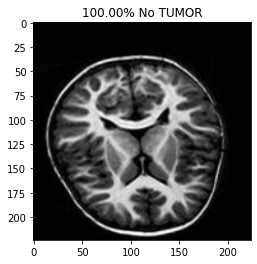

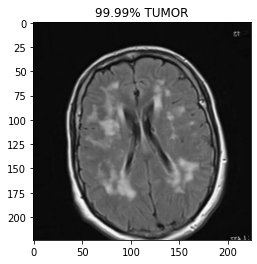

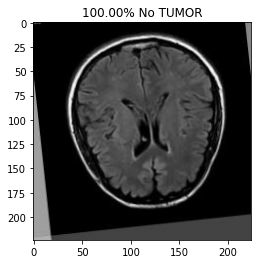

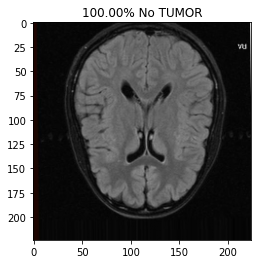

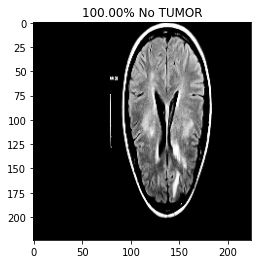

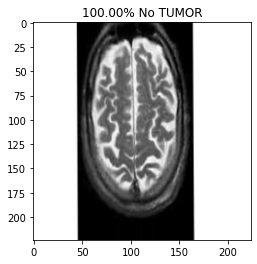

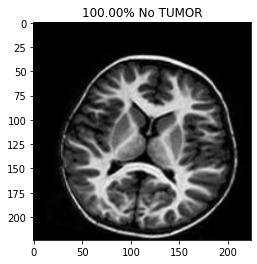

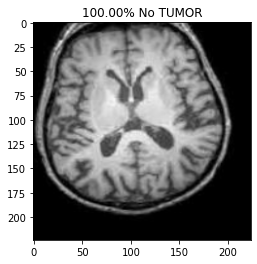

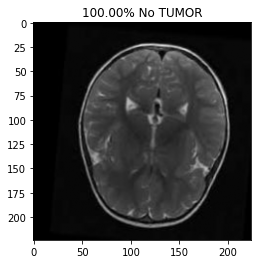

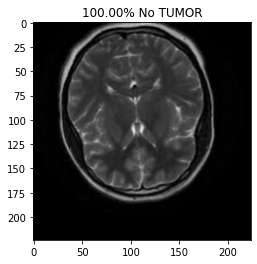

In [88]:
#Prédiction 
y_pred = model.predict(X_test, batch_size=batch_size)

#Visualiser les 10 premiers prédiction 
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

Confusion Matrix without Normalization


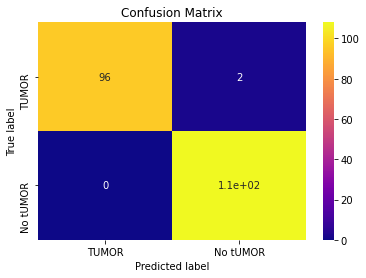

Confusion Matrix with Normalized Values


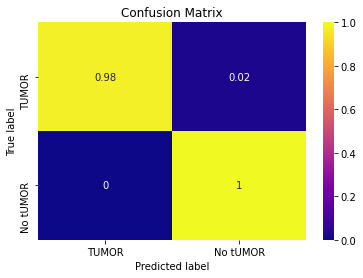

In [89]:
#Plot confusion matrix
def plot_confusion_matrix(normalize):
  classes = ['TUMOR','No tUMOR']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [90]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        98
           1       0.98      1.00      0.99       108

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



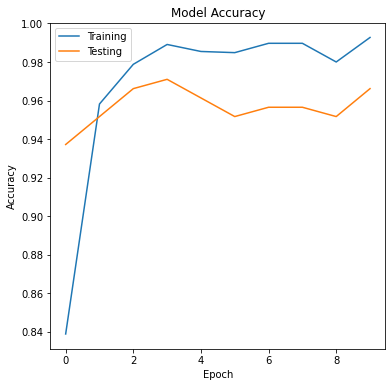

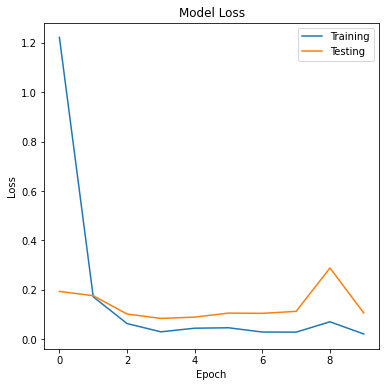

In [91]:
#Accuracy  plot 
plt.figure(figsize=(6,6))

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()

#Loss plot
plt.figure(figsize=(6,6))

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()

#Pré-Trained Modele : ResNet

In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [16]:
# Building Model
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_resnet = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model_resnet.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

# Visualize Model
model_resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [23]:
history3 = model_resnet.fit(X_train, y_train, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs)

Epoch 1/10
52/52 [==============================] - 3s 66ms/step - loss: 0.7370 - accuracy: 0.7748 - val_loss: 0.4965 - val_accuracy: 0.8107
Epoch 2/10
52/52 [==============================] - 3s 64ms/step - loss: 0.6158 - accuracy: 0.7845 - val_loss: 1.9987 - val_accuracy: 0.6165
Epoch 3/10
52/52 [==============================] - 3s 64ms/step - loss: 0.8288 - accuracy: 0.7688 - val_loss: 0.5870 - val_accuracy: 0.7670
Epoch 4/10
52/52 [==============================] - 3s 64ms/step - loss: 0.5318 - accuracy: 0.8130 - val_loss: 0.5692 - val_accuracy: 0.7961
Epoch 5/10
52/52 [==============================] - 3s 64ms/step - loss: 0.5862 - accuracy: 0.7954 - val_loss: 1.0495 - val_accuracy: 0.6311
Epoch 6/10
52/52 [==============================] - 3s 64ms/step - loss: 0.5990 - accuracy: 0.8002 - val_loss: 0.6897 - val_accuracy: 0.7476
Epoch 7/10
52/52 [==============================] - 3s 64ms/step - loss: 0.5525 - accuracy: 0.8220 - val_loss: 0.8309 - val_accuracy: 0.6699
Epoch 8/10
52

In [24]:
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test, y_test)

7/7 [==============================] - 0s 52ms/step - loss: 0.5064 - accuracy: 0.8204


In [134]:
 #Save Model and Weights
model_resnet.save('resnet_rmi.h5')
model_resnet.save_weights('resnet_weights_rmi.hdf5')

In [141]:
# Load saved model
model_resnet = load_model('resnet_rmi.h5')

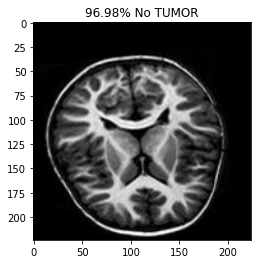

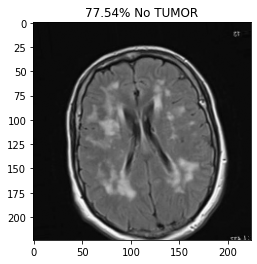

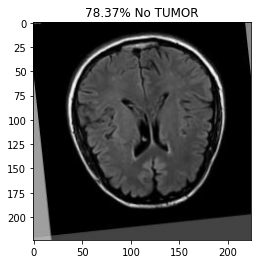

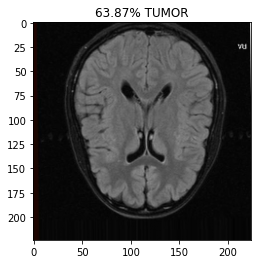

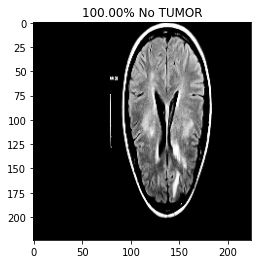

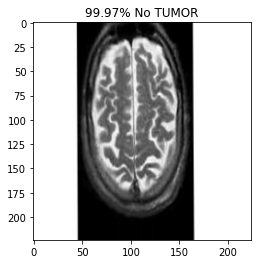

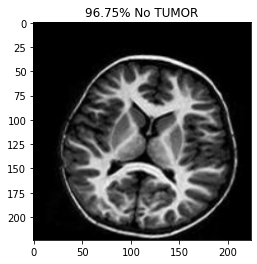

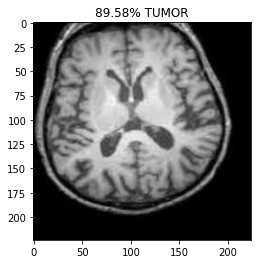

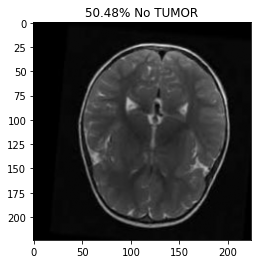

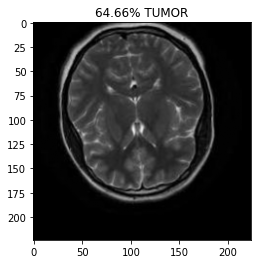

In [97]:
#Prédiction
y_pred = model.predict(X_test, batch_size=batch_size)

#Visualiser les 10 prédictions 
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.imshow(X_test[index])
  plt.show()

Confusion Matrix without Normalization


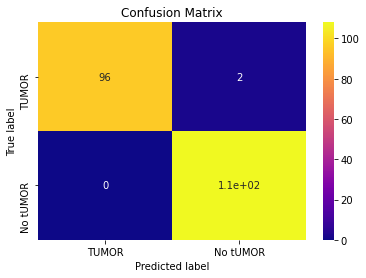

Confusion Matrix with Normalized Values


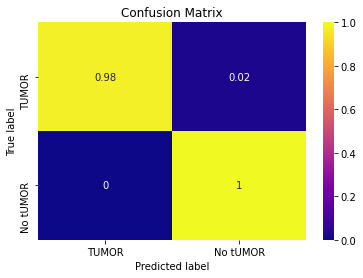

In [98]:
#Plot confusion matrix
def plot_confusion_matrix(normalize):
  classes = ['TUMOR','No tUMOR']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [99]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        98
           1       0.98      1.00      0.99       108

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



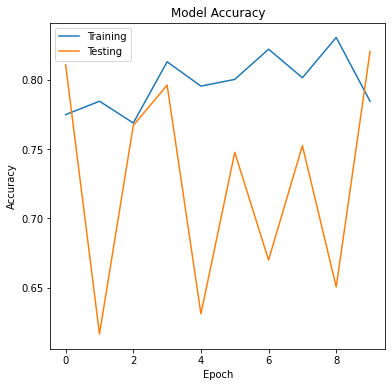

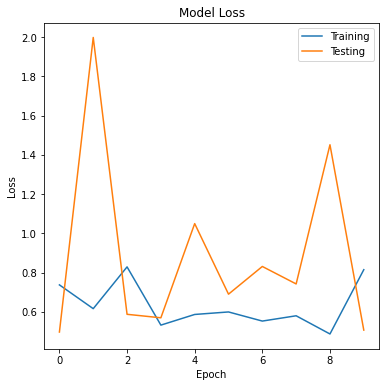

In [25]:
#Accuracy  plot 
plt.figure(figsize=(6,6))

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()

#Loss plot
plt.figure(figsize=(6,6))

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()

#Pré-Trained Modele : VGG16

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [27]:
# Building Model
vggModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_vgg16 = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model_vgg16.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Visualize Model
model_vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [28]:
history4 = model_vgg16.fit(X_train, y_train, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs)

Epoch 1/10
52/52 [==============================] - 6s 93ms/step - loss: 0.7224 - accuracy: 0.6791 - val_loss: 0.3300 - val_accuracy: 0.8495
Epoch 2/10
52/52 [==============================] - 4s 72ms/step - loss: 0.3041 - accuracy: 0.8695 - val_loss: 0.1968 - val_accuracy: 0.9078
Epoch 3/10
52/52 [==============================] - 4s 72ms/step - loss: 0.1759 - accuracy: 0.9360 - val_loss: 0.1572 - val_accuracy: 0.9563
Epoch 4/10
52/52 [==============================] - 4s 72ms/step - loss: 0.1403 - accuracy: 0.9460 - val_loss: 0.1329 - val_accuracy: 0.9612
Epoch 5/10
52/52 [==============================] - 4s 74ms/step - loss: 0.1021 - accuracy: 0.9676 - val_loss: 0.1603 - val_accuracy: 0.9272
Epoch 6/10
52/52 [==============================] - 4s 72ms/step - loss: 0.1188 - accuracy: 0.9485 - val_loss: 0.1427 - val_accuracy: 0.9515
Epoch 7/10
52/52 [==============================] - 4s 72ms/step - loss: 0.0852 - accuracy: 0.9718 - val_loss: 0.1152 - val_accuracy: 0.9612
Epoch 8/10
52

In [29]:
vgg16_loss, vgg16_accuracy = model_vgg16.evaluate(X_test, y_test)

7/7 [==============================] - 0s 58ms/step - loss: 0.0969 - accuracy: 0.9709


In [139]:
# Save Model and Weights
model_vgg16.save('resnet_rmi.h5')
model_vgg16.save_weights('resnet_weights_rmi.hdf5')

In [140]:
# Load saved model
model_vgg16 = load_model('resnet_rmi.h5')

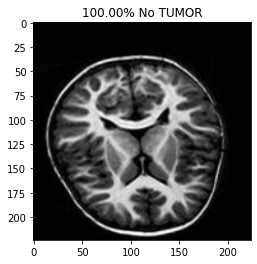

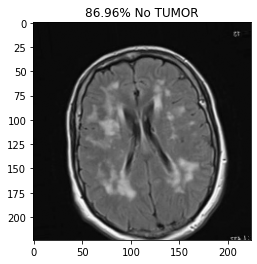

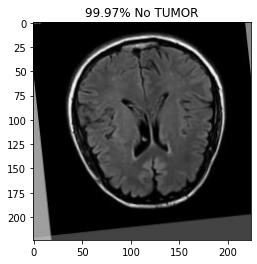

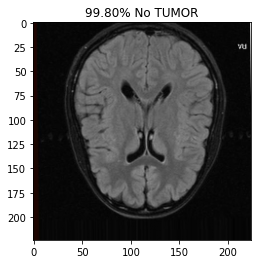

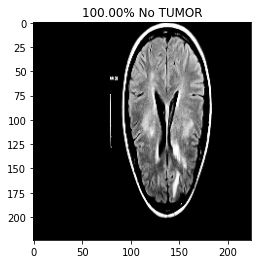

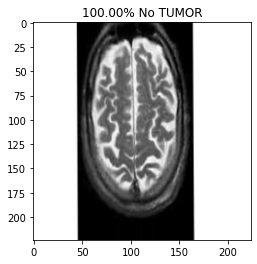

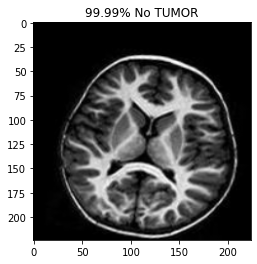

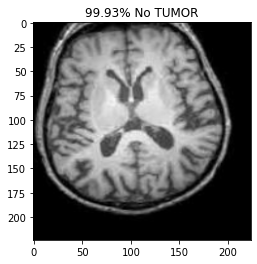

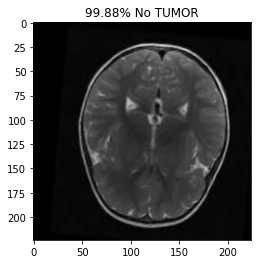

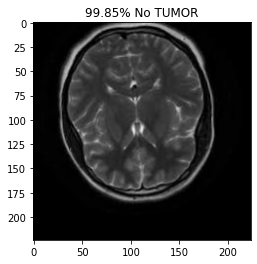

In [108]:
#Prédiction
y_pred = model.predict(X_test, batch_size=batch_size)

#Visualiser les 10 prédictions 
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.imshow(X_test[index])
  plt.show()

Confusion Matrix without Normalization


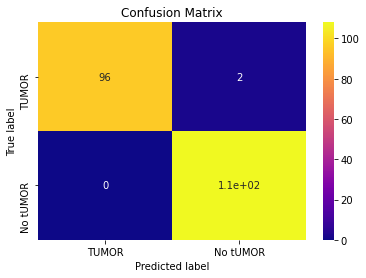

Confusion Matrix with Normalized Values


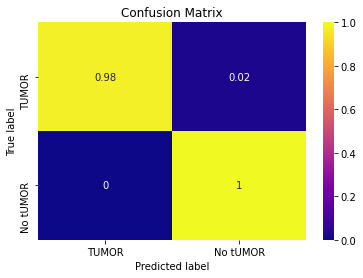

In [109]:
#Plot confusion matrix
def plot_confusion_matrix(normalize):
  classes = ['TUMOR','No tUMOR']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [110]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        98
           1       0.98      1.00      0.99       108

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



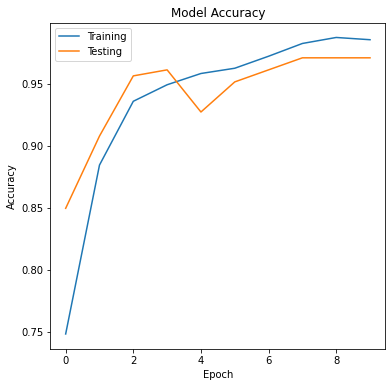

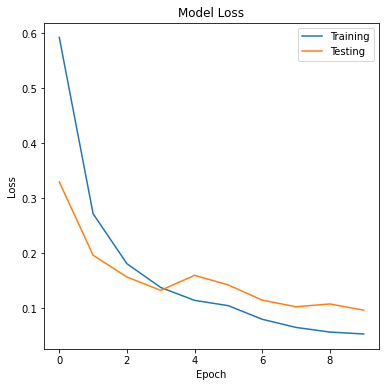

In [30]:
#Accuracy  plot 
plt.figure(figsize=(6,6))

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()

#Loss plot
plt.figure(figsize=(6,6))

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


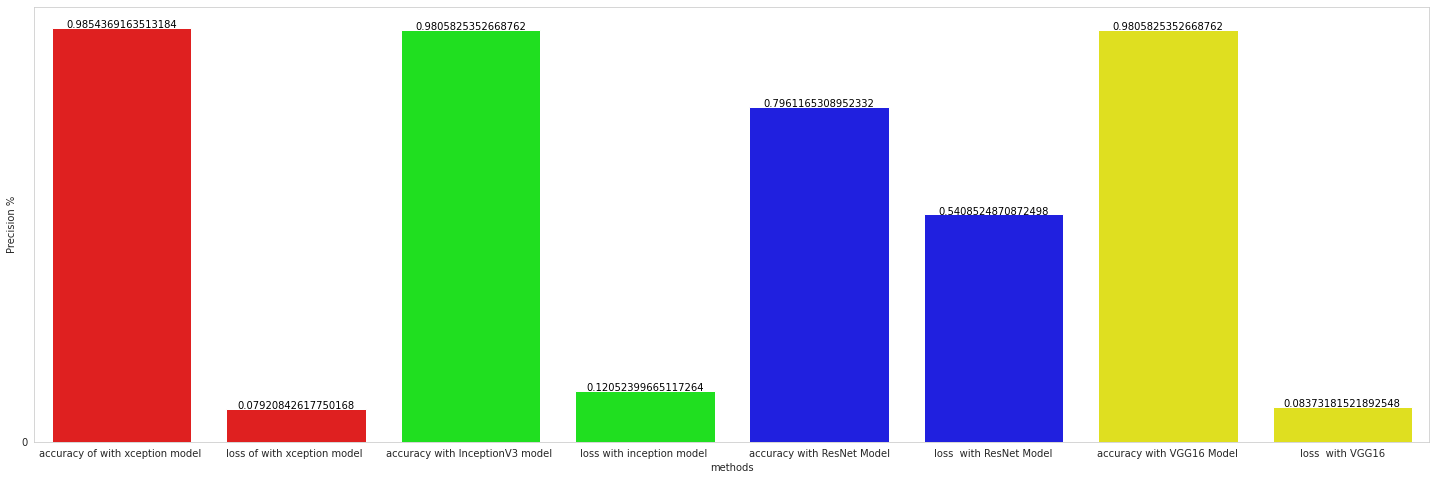

In [142]:
import seaborn as sns
import numpy as np
colors = ["#FF0000", "#FF0000", "#00FF00", "#00FF00","#0000FF","#0000FF","#FFFF00","#FFFF00"]
X=['accuracy of with xception model ','loss of with xception model ','accuracy with InceptionV3 model ',
   'loss with inception model ','accuracy with ResNet Model','loss  with ResNet Model',
   'accuracy with VGG16 Model','loss  with VGG16']
Y=[xception_accuracy , xception_loss , inceptionV3_accuracy , inceptionV3_loss ,
  accuracy_resnet , loss_resnet, vgg16_accuracy, vgg16_loss]
sns.set_style("whitegrid")
plt.figure(figsize=(25,8))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Precision %")
plt.xlabel("methods")
g=sns.barplot(X, Y, palette=colors)
for i in range(len(Y)):
    g.text(i, Y[i],Y[i],color='black', ha="center")
plt.show()
